In [142]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn import cluster, covariance, manifold
from datetime import datetime

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/042%20Vizualizing%20Stock%20Market%20Structures%20using%20Cluster%20Analysis%20in%20Python.ipynb
#https://www.relataly.com/crypto-market-cluster-analysis-using-affinity-propagation-python/8114/


In [143]:
assetMain='ACWI'
assetList=['ACWI','AAXJ','ETH-USD']
colTarget='ADR_25'

data_path='data/N-AssetPort-Y20-22.csv'

# Step #1 Load Extract & Transform the Amibroker Data

In [144]:
dfAllAsset=pd.read_csv(data_path, parse_dates=['Date/Time'],dayfirst=True)
dfAllAsset.rename(columns={'Date/Time':'Date'},inplace=True,)
dfAllAsset['Date']=dfAllAsset['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
dfAllAsset.set_index('Date',inplace=True)
print(dfAllAsset.info())
dfAllAsset.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19573 entries, 2020-01-02 to 2022-12-09
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ticker   19573 non-null  object 
 1   OtC_Pct  19573 non-null  float64
 2   ROC_1    19573 non-null  float64
 3   ROC_5    19573 non-null  float64
 4   ROC_15   19573 non-null  float64
 5   ROC_25   19573 non-null  float64
 6   ADR_5    19573 non-null  float64
 7   ADR_15   19573 non-null  float64
 8   ADR_25   19573 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.5+ MB
None


,Ticker,OtC_Pct,ROC_1,ROC_5,ROC_15,ROC_25,ADR_5,ADR_15,ADR_25
Date,,,,,,,,,
2022-12-05,XLK,0.0090,-1.66,1.81,-0.02,2.72,3.27,2.60,2.89
2022-12-06,XLK,0.0204,-2.14,0.62,-1.32,1.87,3.62,2.70,2.98
2022-12-07,XLK,0.0015,-0.51,-4.68,-2.99,2.21,2.66,2.61,2.92
2022-12-08,XLK,-0.0107,1.64,-3.25,-0.04,7.60,2.71,2.66,2.78
2022-12-09,XLK,0.0017,-0.61,-3.29,-0.78,10.18,2.68,2.62,2.79


In [145]:
assetList=list(dfAllAsset['Ticker'].unique())

print(assetList)

['82823.HK', 'AAXJ', 'ACWI', 'BMSCG.BK', 'ASEA', 'CSSX5E.MI', 'EEM', 'BNB-USD', 'ETH-USD', 'GLD', 'IGM', 'IWQU.L', 'IWVL.L', 'IWM', 'KXI', 'MATIC-USD', 'MCHI', 'PBD', 'QQQ', 'REET', 'SPY', 'USO', 'USDTHB=X', 'XLV', 'XLK']


In [146]:


assetDict={}

for asset in assetList:
  dfTemp=dfAllAsset.query('Ticker==@asset')

  dfTemp.sort_index(inplace=True)

  dfTemp=dfTemp.drop(columns=['Ticker'])
  dfTemp=dfTemp[[colTarget]]  
  
  dfTemp=dfTemp.rename(columns={colTarget:f'{asset}_{colTarget}'})  

  assetDict[asset]=dfTemp
    
  # print(f"{asset} - {len(dfTemp)}") 
  # print(dfTemp.head(3))    
  # print(dfTemp.tail(3))  
  # print("-------------------------")
dfMain=assetDict[assetMain]
del assetDict[assetMain]
assetList.remove(assetMain)


In [147]:
for item in assetList:
    dfMain=pd.merge(dfMain,assetDict[item],how='left',left_index=True,right_index=True)
    
#dfMain=dfMain.reset_index(drop=True)
dfMain=dfMain.dropna()

print(dfMain.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 649 entries, 2020-01-02 to 2022-12-09
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACWI_ADR_25       649 non-null    float64
 1   82823.HK_ADR_25   649 non-null    float64
 2   AAXJ_ADR_25       649 non-null    float64
 3   BMSCG.BK_ADR_25   649 non-null    float64
 4   ASEA_ADR_25       649 non-null    float64
 5   CSSX5E.MI_ADR_25  649 non-null    float64
 6   EEM_ADR_25        649 non-null    float64
 7   BNB-USD_ADR_25    649 non-null    float64
 8   ETH-USD_ADR_25    649 non-null    float64
 9   GLD_ADR_25        649 non-null    float64
 10  IGM_ADR_25        649 non-null    float64
 11  IWQU.L_ADR_25     649 non-null    float64
 12  IWVL.L_ADR_25     649 non-null    float64
 13  IWM_ADR_25        649 non-null    float64
 14  KXI_ADR_25        649 non-null    float64
 15  MATIC-USD_ADR_25  649 non-null    float64
 16  MCHI_ADR_25       649 non

In [148]:
start_date=dfMain.index.max().strftime('%b%y')
end_date=dfMain.index.min().strftime('%b%y')
print(f'AssetPort-{colTarget}-{start_date}_{end_date}')
#dfMain.to_csv(f'AssetPort-{colTarget}-{start_date}_{end_date}.csv',index=True)

AssetPort-ADR_25-Dec22_Jan20


# Step #2 Plotting Stock Charts


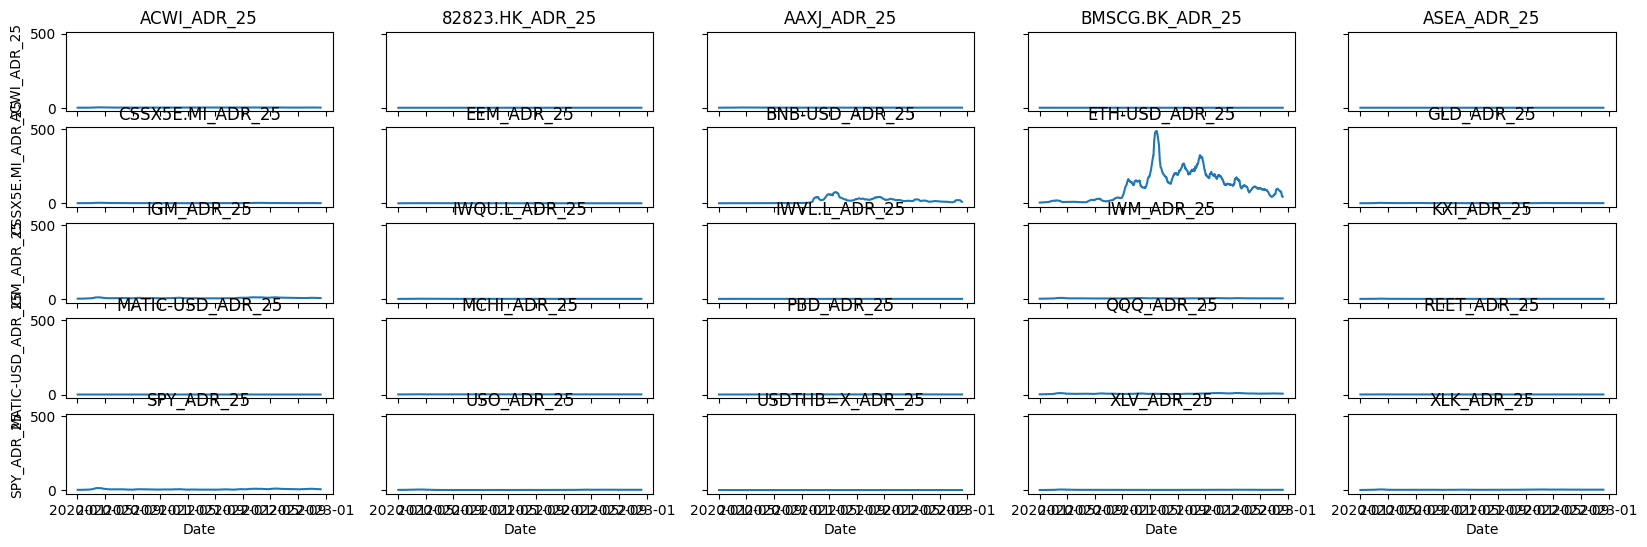

In [149]:
# Create Prices Charts for all Cryptocurrencies
list_length = dfMain.shape[1]
ncols = 5
nrows = int(round(list_length / ncols, 0))
height = list_length/2 if list_length > 30 else 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20, height))
for i, ax in enumerate(fig.axes):
        if i < list_length:
            sns.lineplot(data=dfMain, x=dfMain.index, y=dfMain.iloc[:, i], ax=ax)
            ax.set_title(dfMain.columns[i])
plt.show()

# Step #3 Clustering Cryptocurrencies using Affinity Propagatio

In [150]:
names=[  x.replace(colTarget,'') for x in list(dfMain.columns)]
names=[  x.replace('_','') for x in names]
# names=list(dfMain.columns)
names

['ACWI',
 '82823.HK',
 'AAXJ',
 'BMSCG.BK',
 'ASEA',
 'CSSX5E.MI',
 'EEM',
 'BNB-USD',
 'ETH-USD',
 'GLD',
 'IGM',
 'IWQU.L',
 'IWVL.L',
 'IWM',
 'KXI',
 'MATIC-USD',
 'MCHI',
 'PBD',
 'QQQ',
 'REET',
 'SPY',
 'USO',
 'USDTHB=X',
 'XLV',
 'XLK']

In [151]:
# Transpose the data to structure prices along columns
X = dfMain.copy()
X = np.array(X)
X[:3]

array([[0.37, 0.01, 0.42, 0.05, 0.12, 0.98, 0.28, 0.56, 5.41, 0.73, 1.64,
        0.24, 0.22, 1.3 , 0.27, 0.  , 0.48, 0.09, 1.44, 0.21, 1.77, 1.49,
        0.24, 0.71, 0.68],
       [0.39, 0.01, 0.42, 0.05, 0.13, 0.98, 0.28, 0.57, 5.56, 0.71, 1.7 ,
        0.24, 0.23, 1.32, 0.27, 0.  , 0.48, 0.09, 1.5 , 0.22, 1.82, 1.54,
        0.24, 0.74, 0.7 ],
       [0.41, 0.02, 0.43, 0.06, 0.13, 1.03, 0.28, 0.59, 5.7 , 0.76, 1.83,
        0.25, 0.23, 1.37, 0.28, 0.  , 0.48, 0.09, 1.59, 0.22, 1.91, 1.54,
        0.21, 0.76, 0.74]])

In [155]:

# Define an edge model based on covariance
edge_model = covariance.GraphicalLassoCV()

# Standardize the time series
edge_model.fit(X)

# Group cryptos to clusters using affinity propagation
# The number of clusters will be determined by the algorithm
cluster_centers_indices , labels = cluster.affinity_propagation(edge_model.covariance_, random_state=1)
n_labels = labels.max()
print(f"{n_labels} Clusters")

print(cluster_centers_indices)
print(labels)

7 Clusters
[ 0  3  8 12 18 20 22 24]
[0 6 4 1 6 0 6 2 2 0 1 2 3 0 7 7 7 7 4 3 5 6 6 4 7]


In [156]:
labelsList= list(zip(names, labels))
dfClusterSummary=pd.DataFrame (labelsList,columns=['Asset','Cluster'])
dfClusterSummary=dfClusterSummary.sort_values(by='Cluster')
dfClusterSummary

,Asset,Cluster
0,ACWI,0
13,IWM,0
5,CSSX5E.MI,0
9,GLD,0
3,BMSCG.BK,1
10,IGM,1
11,IWQU.L,2
7,BNB-USD,2
8,ETH-USD,2
19,REET,3


In [157]:
dfClusterSummary.groupby(['Cluster'])[['Asset']].size()

Cluster
0    4
1    2
2    3
3    2
4    3
5    1
6    5
7    5
dtype: int64